<a id="up"></a>

# Description du Notebook
-------------
**Objectifs** : Visualiser les données patient par patient puis dans leur ensemble. Repérer les données extrêmes et les corriger.

**Visualisation des données** : Scatter plots, Régression Polynomiale

## Sommaire
-------------
- [Import des données et des packages](#import)
- [Scatter plots aléatoires (3x3)](#scatter)
- [Regression Polynomiale (< 20 ans)](#polreg)
- [Interprétation des résultats](#interpret)
- [Validation du modèle](#validaton)
- [À Faire](#to-do)


<a id="import"></a>

## Import des données et des packages [(^)](#up)
--------------

In [30]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import r2_score
import seaborn as sns

start = timeit.default_timer()

# Load data
data = pd.read_csv('mean_std_v2.csv', dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')
lvl1 = pd.read_csv('data/priority_lvl/priority_lvl1.csv', dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')


<a id="scatter"></a>

## Scatter plots aléatoires (3x3) [(^)](#up)
---------------------

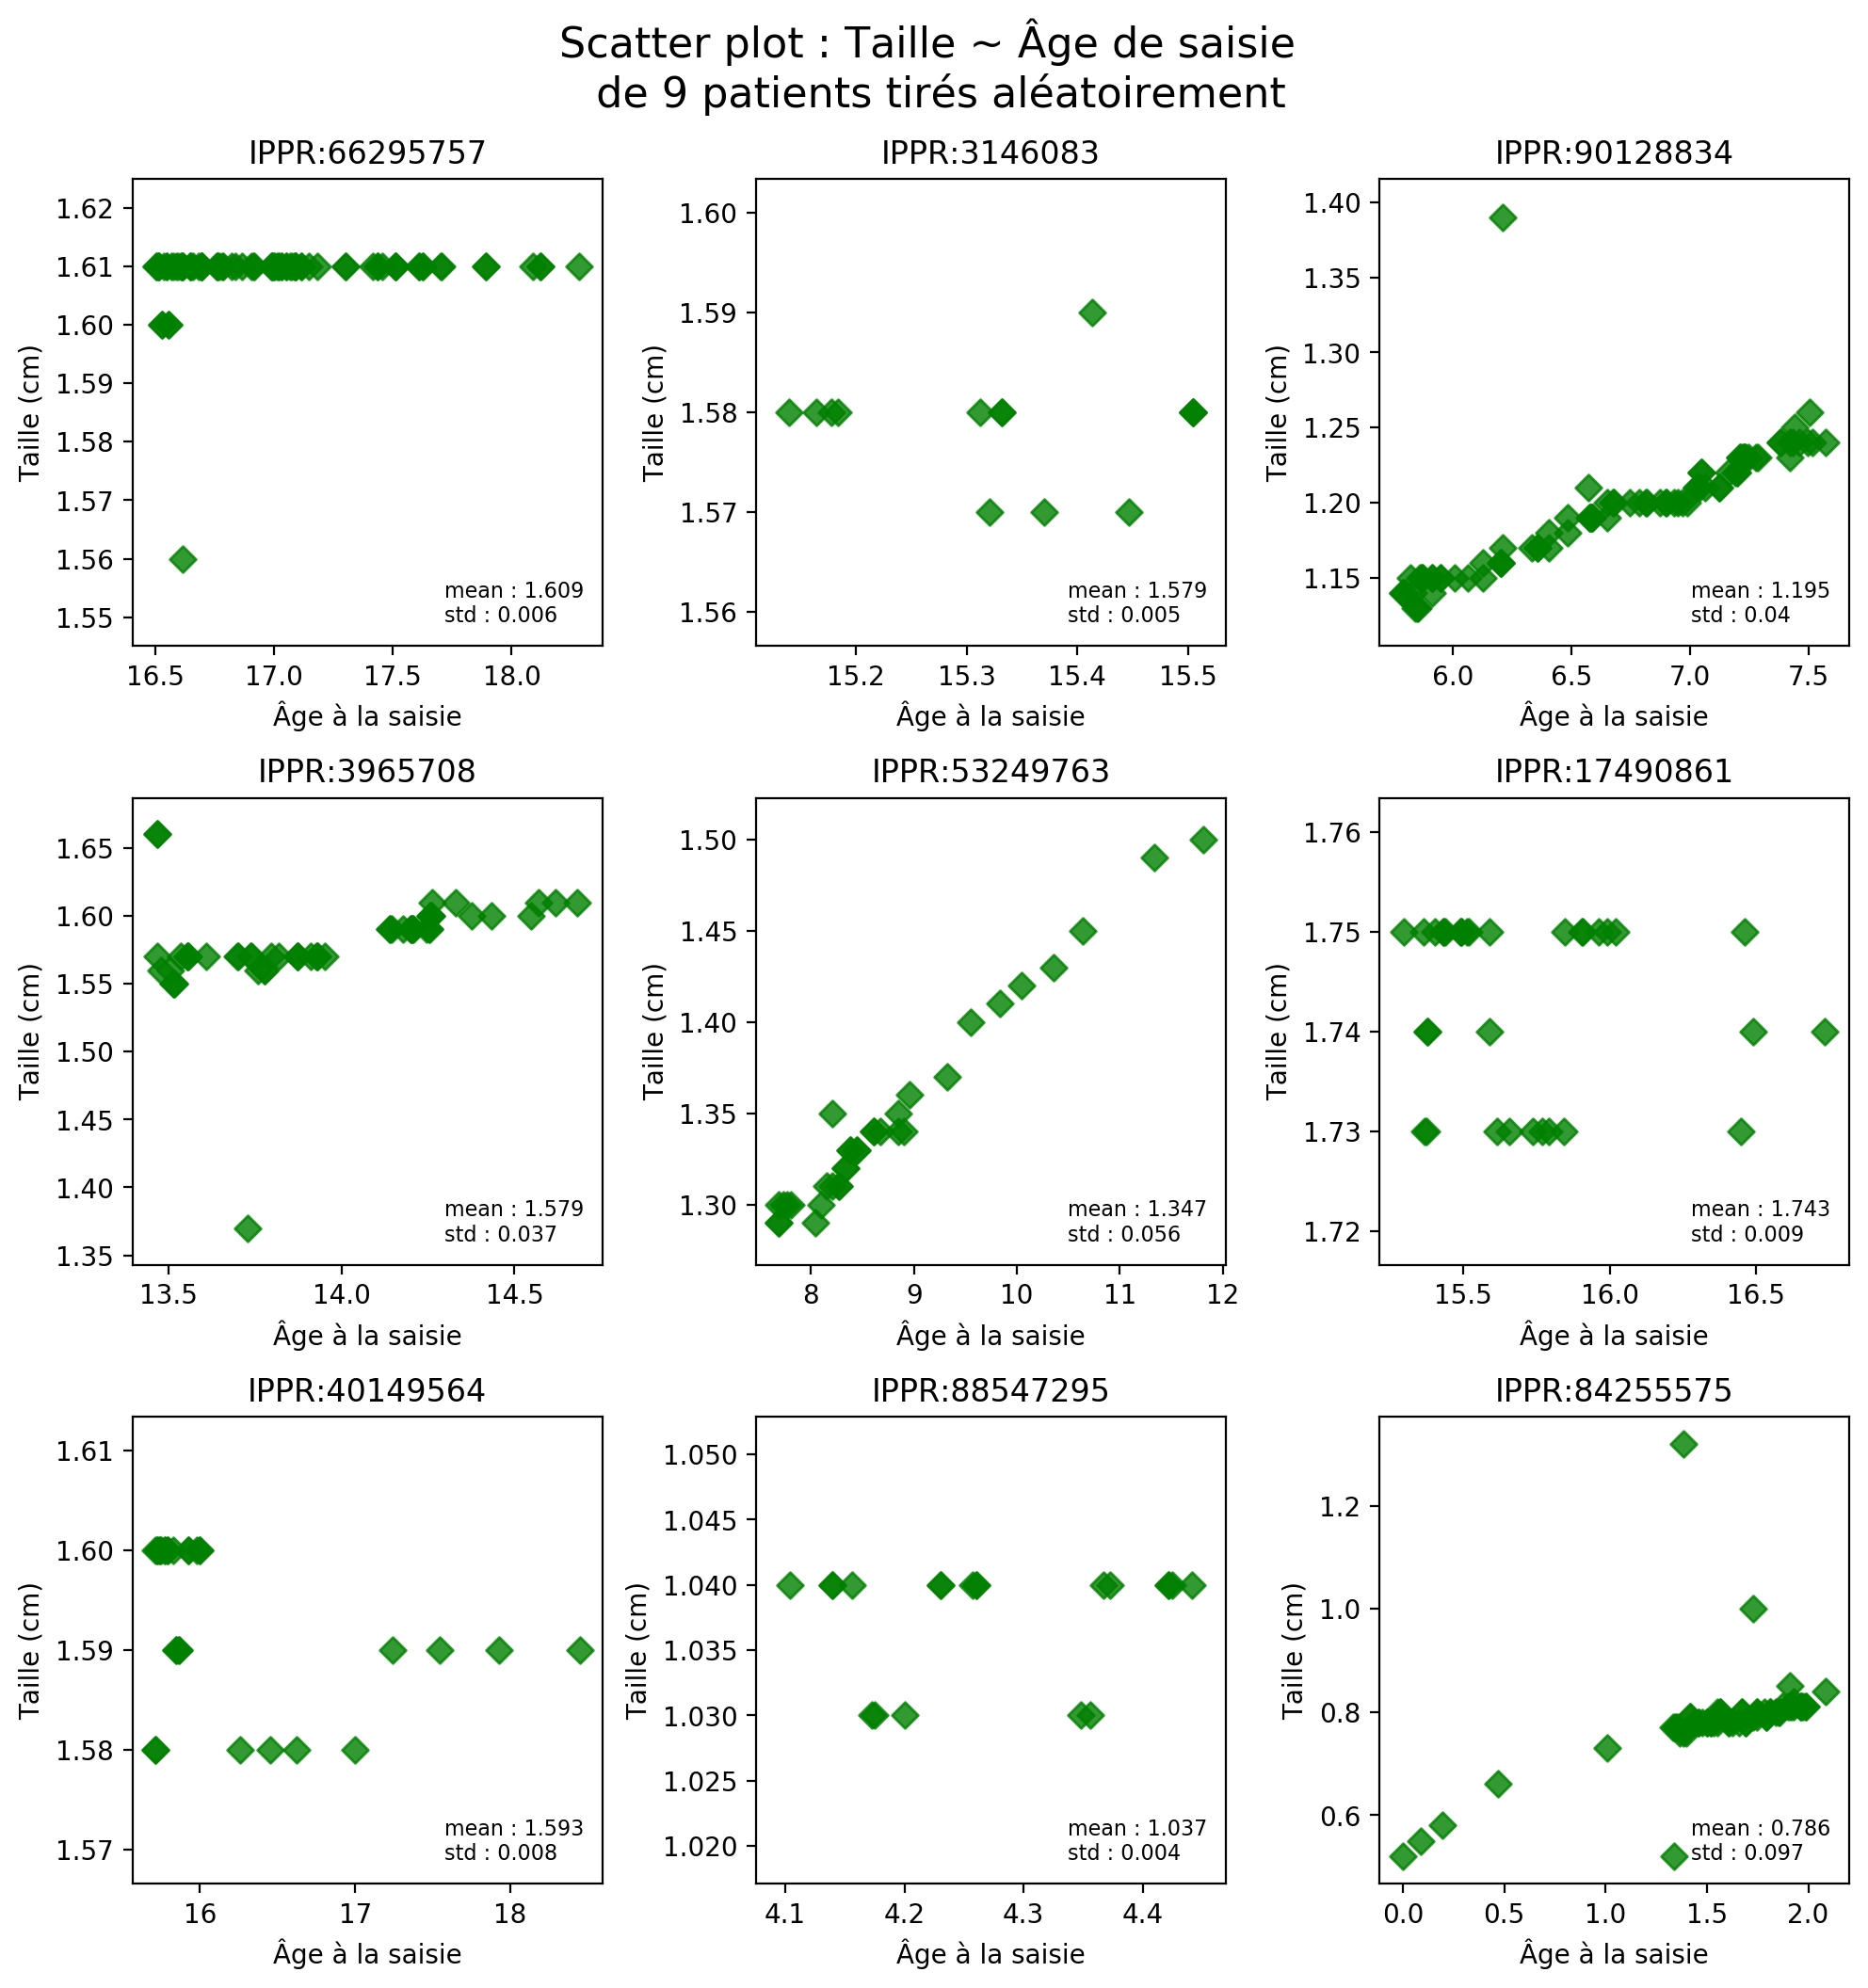

In [35]:
# Scatter plots 3x3 de 9 patients choisis aléatoirements
data = data[data.age_at_entry < 7200]
sample_ippr = data['IPPR'].sample(n=9)
sample_ippr = np.array(sample_ippr)
data_sample = data[data["IPPR"].isin(sample_ippr)]

def scatter_3by3(df):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[10, 10], dpi=200)
    for i, axi in enumerate(ax.flat):
        ippri = sample_ippr[i]
        datai = df[df['IPPR'] == ippri]
        xi = datai['age_at_entry'] / 365
        yi = datai['Taille']
        axi.scatter(xi, yi, c='g', marker = "D", s=50, alpha = 0.8)
        axi.set_ylabel("Taille (cm)")
        axi.set_xlabel("Âge à la saisie")
        axi.set_title("IPPR:{}".format(ippri))
        
        # Affichage mean et std
        meani = datai['mean'].unique()
        stdi = datai['std'].unique()
        m_s_lbl = "mean : " + str(round(meani[0],3)) + "\nstd : " + str(round(stdi[0],3))
        at = AnchoredText(m_s_lbl,
                  prop=dict(size=8), frameon=False,
                  loc='lower right',
                  )
        axi.add_artist(at)
        
        # Affichage Best Fit Line
        # m, b = np.polyfit(xi, yi, 1)
        # axi.plot(xi, m*xi + b, color='r')
        
    plt.suptitle("Scatter plot : Taille ~ Âge de saisie \n de 9 patients tirés aléatoirement", y=1.05, size=16)
    plt.tight_layout(pad=1)
    plt.show()

scatter_3by3(data_sample)

<a id="polreg"></a>

## Régression Polynomiale (< 20 ans) [(^)](#up)
------------------

-----------------------------------
Degré: 1
coeffs:  
5.542 x + 77.27

r2: 0.9208076295616414
-----------------------------------
Degré: 5
coeffs:            5            4          3         2
0.0001128 x - 0.008534 x + 0.2151 x - 2.417 x + 18.14 x + 56.08

r2: 0.9481324792215041


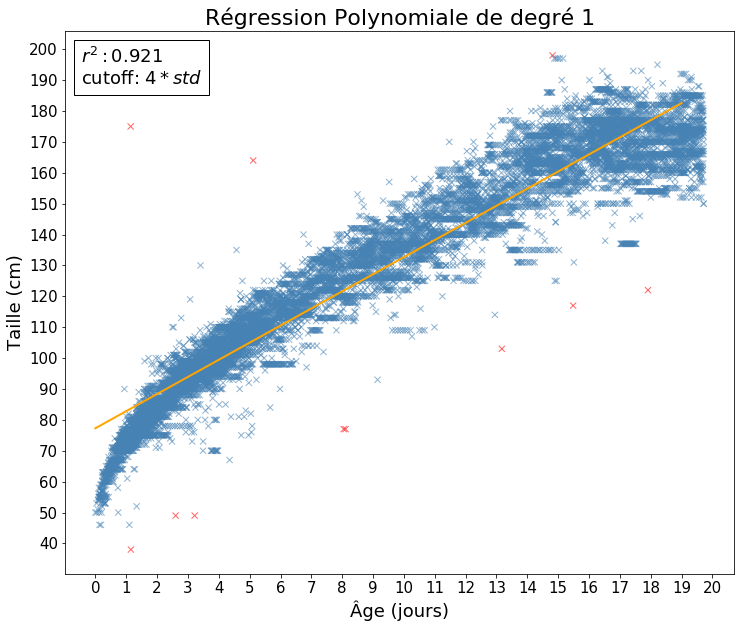

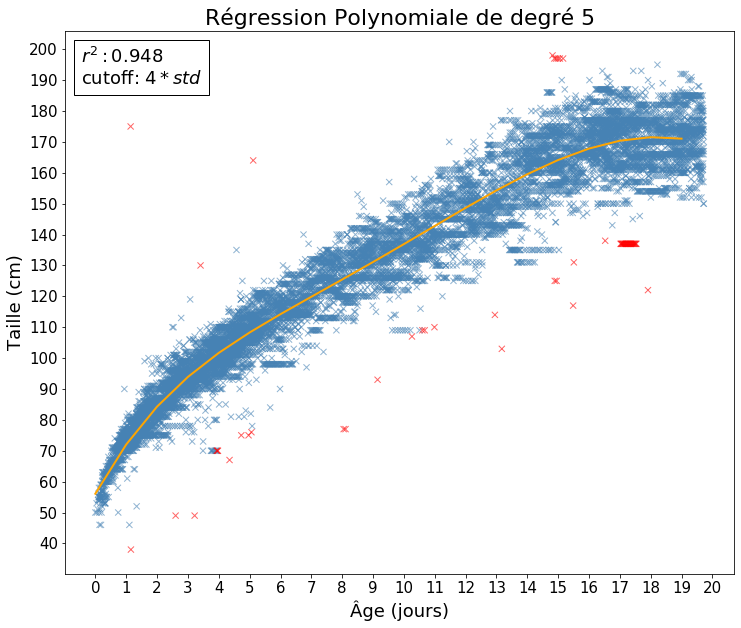

In [32]:
data20 = lvl1[lvl1.age_at_entry < 7200]
data20 = data20[data20.age_at_entry  > 0] # two points < 0
data20.Taille = data20.Taille.apply(lambda x: x*100)

# Keep 50% of observations
# data20 = data20.sample(frac=0.5)

x = data20['age_at_entry'] / 365
y = data20['Taille']

def regression(order):
    # polynomial curve fitting (order=5)
    #order = 3
    p = np.polyfit(x, y, order)

    # model
    predict = np.poly1d(p)
    print('{}\nDegré: {}\ncoeffs: {}\n'.format('-'*35, order, predict))

    # r_square (r2=0.94)
    r2 = r2_score(y, predict(x))
    print('r2: {}'.format(r2))

    sd_cutoff = 4
    pred = predict(x)
    delta = y - pred
    sd_p = np.std(delta)
    ok = abs(delta) < sd_p * sd_cutoff

    # Anchored Text
    def draw_text(ax):
        at = AnchoredText("$r^2: {}$\ncutoff: $4*std$".format(round(r2,3)),
                          loc='upper left', prop=dict(size=18), frameon=True,
                          )
        ax.add_artist(at)

    # Plotting
    figure, ax = plt.subplots(figsize=(12,10))
    draw_text(ax)
    x_lm = range(0,20)
    ax.scatter(x,y, color=np.where(ok, 'steelblue', 'r'), marker='x', s=38, alpha=0.6, linewidth=1)
    ax.plot(x_lm, predict(x_lm), c='orange', linewidth=2)
    ax.set_xlabel('Âge (jours)', fontsize=18)
    ax.set_xticks(np.arange(min(x), max(x)+1, 1.0))
    ax.set_ylabel('Taille (cm)', fontsize=18)
    ax.set_yticks(np.arange(min(y)+2, max(y)+3, 10.0))
    ax.tick_params(labelsize=15)
    # ax.grid(b=True, alpha=0.5)
    ax.set_title("Régression Polynomiale de degré {}".format(order), fontsize=22)
    

regression(1)
regression(5)

<a id="interpret"></a>

## Interprétation des résultats [(^)](#up)
*Régression Polynomiale* : Cas particulier de Régression Linéaire Multiple, où les observations sont construites à partir des puissances d'une seule variable. Les coefficients calculés par la méthode des moindres carrés déterminent la droite de régression d'équation : 

$$y = 0.0001128 x^{5} - 0.008534 x^{4} + 0.2151 x^{3} - 2.417 x^{2} + 18.14 x + 56.08 $$

*Choix de l'ordre* : En comparant visuellement l'aspect des courbes calculées, l'ordre du ploynome a été fixé à 5. En effet, c'est la courbe qui semble la mieux ajustée à la distribution des points dans le graphique.  En augmentant le degré du polynôme, le gain sur le $r^{2}$ semble converger lentement vers une valeur ~0.95 (cf Tableau suivant). De plus, augmenter le degré du polynôme complexifie le modèle de régression et risque de nous mener à l'*overfitting*.

|Ordre|1|2|3|4|5|6|7|...|
|:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:||
|$r^{2}$|0.9208|0.94445|0.94446|0.9480|0.948132|0.9481996|0.94901|...|


Le choix du *sd cut-off* càd le nombre d'écart-types destinés à isoler les outliers est fixé à 4.

<a id='validation'></a>

## Validation du modèle [[Source](https://www.math.univ-toulouse.fr/~barthe/M1modlin/poly.pdf)] [(^)](#up)
Une fois le modèle mis en œuvre, on doit vérifier a posteriori le “bien-fondé statistique” de ce
modèle du point de vue de la normalité des résidus et de l’adéquation de la valeur ajustée ybi à la
valeur observée yi et de l’absence de données aberrantes. 
Pour contrôler l'ajustement du modèle on peut analyser : 

- Le graphe des $n$ points ($y_{i}$, $\hat{y}_{i}$) qui “doivent” être à peu près alignés selon la droite de pente 1. $\hat{y}_{i}$ sont les valeurs ajustées ou valeurs prédites par le modèle.
- Le graphe des $n$ points ($e_{i}$, $\hat{y}_{i}$) qui doit correspondre à celui de deux variables non-corrélées. $\hat{e}_{i}$ sont les résidus calculés tels que $\hat{e}_{i} = y_{i} - \hat{y}_{i}$.

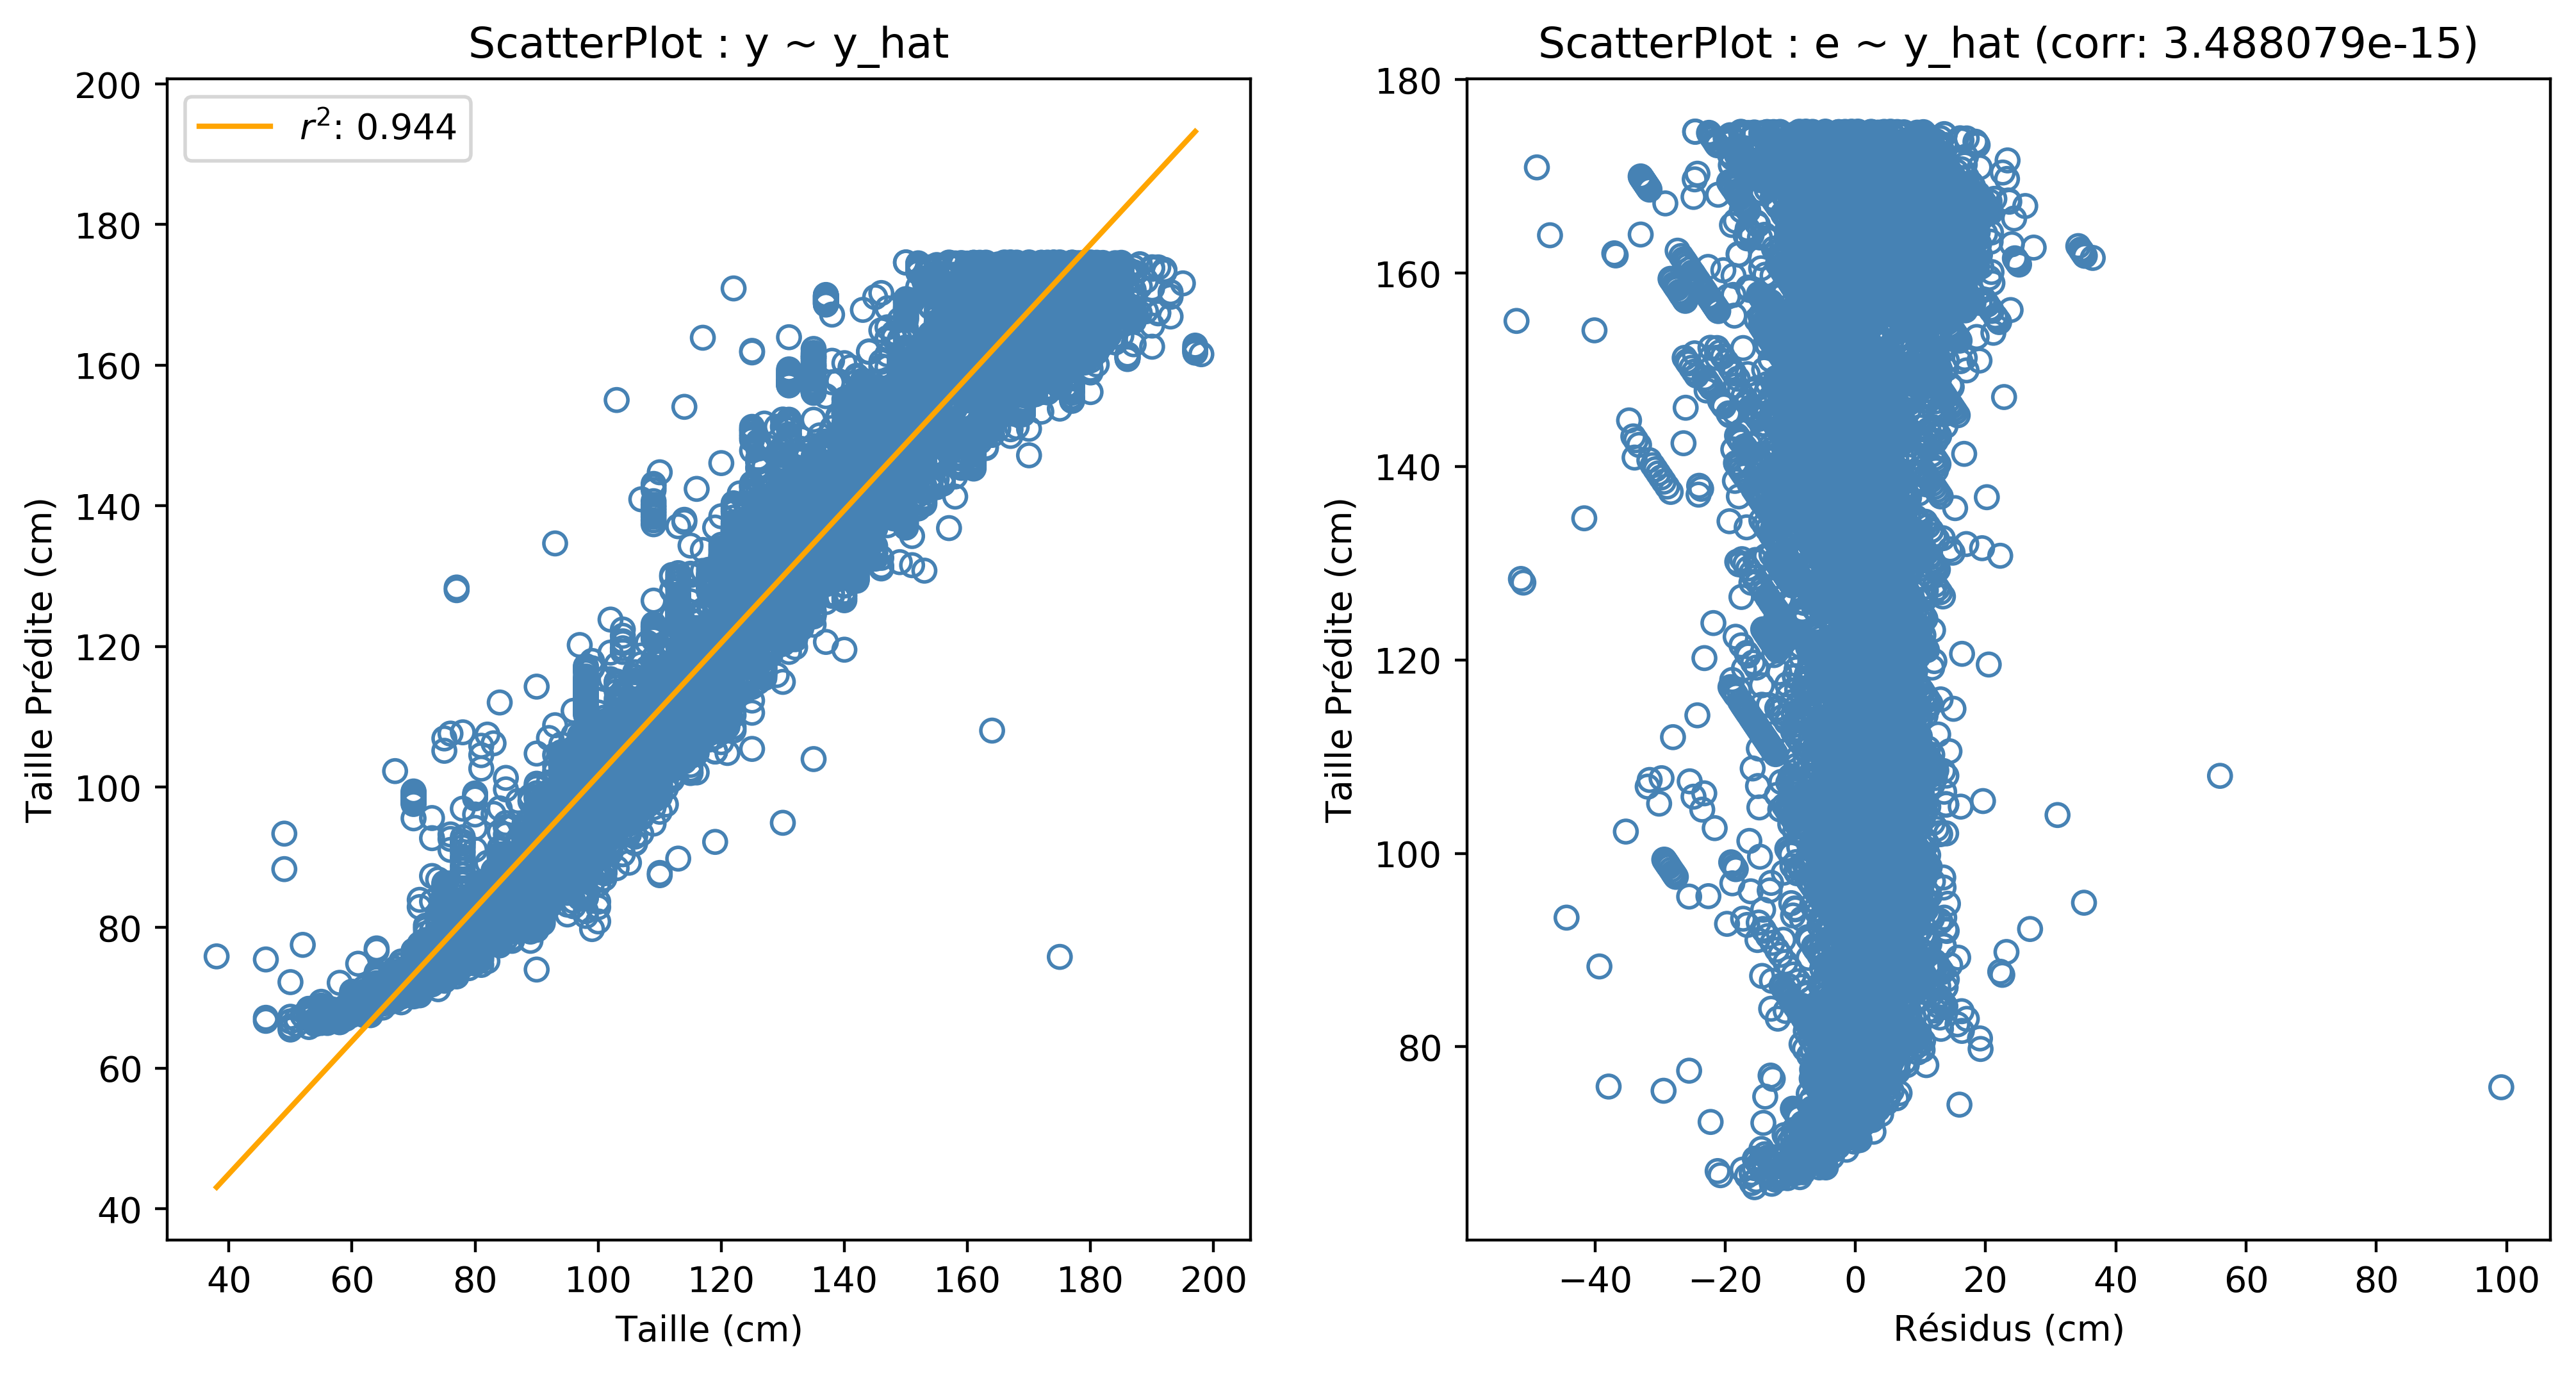

In [33]:
# --------------
# Nomenclature
# y -> y
# y_hat -> pred
# residuals -> e
e = y - pred 
# --------------
# Scatter Plot
figure, ax_s = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=400)
def scatter_plt(x, y, col):
    ax_s[col].scatter(x, y, s = 40, color = 'b', edgecolors ='steelblue', facecolors='none', linewidth=1)
    ax_s[col].set_xlabel('Résidus (cm)')
    ax_s[col].set_ylabel('Taille Prédite (cm)')
    
    p = np.polyfit(x, y, 1)
    predict = np.poly1d(p)
    r2 = r2_score(y, predict(x))
    
    corr = np.corrcoef(x,y)
    
    minx = round(int(min(x)), 1)
    maxx = round(int(max(x)) ,1)
    x_lm = range(minx, maxx)
    
    if col == 0:
        ax_s[col].plot(x_lm, predict(x_lm), c='orange', label='$r^2$: {}'.format(np.round(r2, 3)))
        ax_s[col].set_xlabel('Taille (cm)')
        ax_s[col].legend()
    
    ax_s[0].set_title('ScatterPlot : y ~ y_hat')
    ax_s[1].set_title('ScatterPlot : e ~ y_hat (corr: {})'.format("{:e}".format(corr[1][0])))

    
scatter_plt(y, pred, 0)
scatter_plt(e, pred, 1)

<a id='to-do'></a>

## À faire [(^)](#up)
-----------
- ~~Régression Linéaire~~
- Analyse ANOVA
- ~~Plot : représentation des résidus en fonction des valeurs ajustées~~

In [34]:
stop = timeit.default_timer()
print()
print('Time:  ', str(round(stop - start, 4)), 's\n\t' + str(round((stop - start) / 60, 4)) + ' m ')


Time:   8.1381 s
	0.1356 m 
